# To do:

### SED
* ~~Remake SED without LD^2 to compare~~
* ~~Change z binning (0.1 increments)~~
* ~~Remove median~~
* ~~Variable wl bin sizes~~

### Median iBand magnitude
* ~~Apparent iband flux~~

### ML
* ~~Use all narrow bands, as well as broad band photometry,~~ weights?
* Single reg, multiple times to build errors?

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import matplotlib


#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [3]:
# MAY NEED ADJUSTING DEPEDNING ON DEVICE/OS RUNNING
# data = pd.read_csv("../../Data/PAUS_866.csv")
# data['band'] = data['band'].str.slice(start=2).astype(int)
# Converts 'band' column from type string to int

data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")

In [4]:
data.columns.values

array(['ref_id', 'zb', 'odds', 'pz_width', 'zb_mean', 'chi2', 'n_band',
       'ebv', 'qz', 'best_run', 'production_id', 'paudm_id', 'ra', 'dec',
       'zp_gal', 'zl68_gal', 'zu68_gal', 'zl99_gal', 'zu99_gal', 'zp_sec',
       'dchi', 'imag', 'ei', 'i_auto', 'nbfilt', 'mod_gal', 'type',
       'umag', 'bmag', 'vmag', 'gmag', 'rmag', 'zmag', 'icmag', 'jmag',
       'kmag', 'mv', 'ebv_gal', 'ebv_int', 'acs_a_image', 'acs_b_image',
       'acs_theta_image', 'acs_mag_auto', 'acs_magerr_auto', 'zspec',
       'conf', 'f814w', 'zfits', 'r50', 'sersic_n_gim2d', '_col50',
       '_col54', 'n_coadd', 'run', '_col57', 'band0', 'band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9',
       'band10', 'band11', 'band12', 'band13', 'band14', 'band15',
       'band16', 'band17', 'band18', 'band19', 'band20', 'band21',
       'band22', 'band23', 'band24', 'band25', 'band26', 'band27',
       'band28', 'band29', 'band30', 'band31', 'band32', 'band33',
       'band34', '

# SED

In [5]:
#CUT
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 

data_sample = data.loc[(data['n_bands']>=30)]# & mask & (data['zspec']!=0)]
# data_sample.shape
# data_sample['n_bands'].unique()

In [6]:
lum_dists_1d = cosmo.luminosity_distance(data_sample['zb']).value
luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
# print(luminosity_distances.shape)
# bands = data['band']
z_photos = data_sample['zb']
# object_ids = data.loc[data['zb'].notna()]['ref_id_2']
# fluxs = data.loc[data['zb'].notna()]['flux']

#GENERATE Luminosity Distances

/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/home/andrew/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


wl bin step = 7.42
wl bin step = 6.95
wl bin step = 6.53
wl bin step = 6.17
wl bin step = 5.84
wl bin step = 5.55
wl bin step = 5.28
wl bin step = 5.04
wl bin step = 4.82
wl bin step = 4.62
wl bin step = 4.43


/home/andrew/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:1478: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


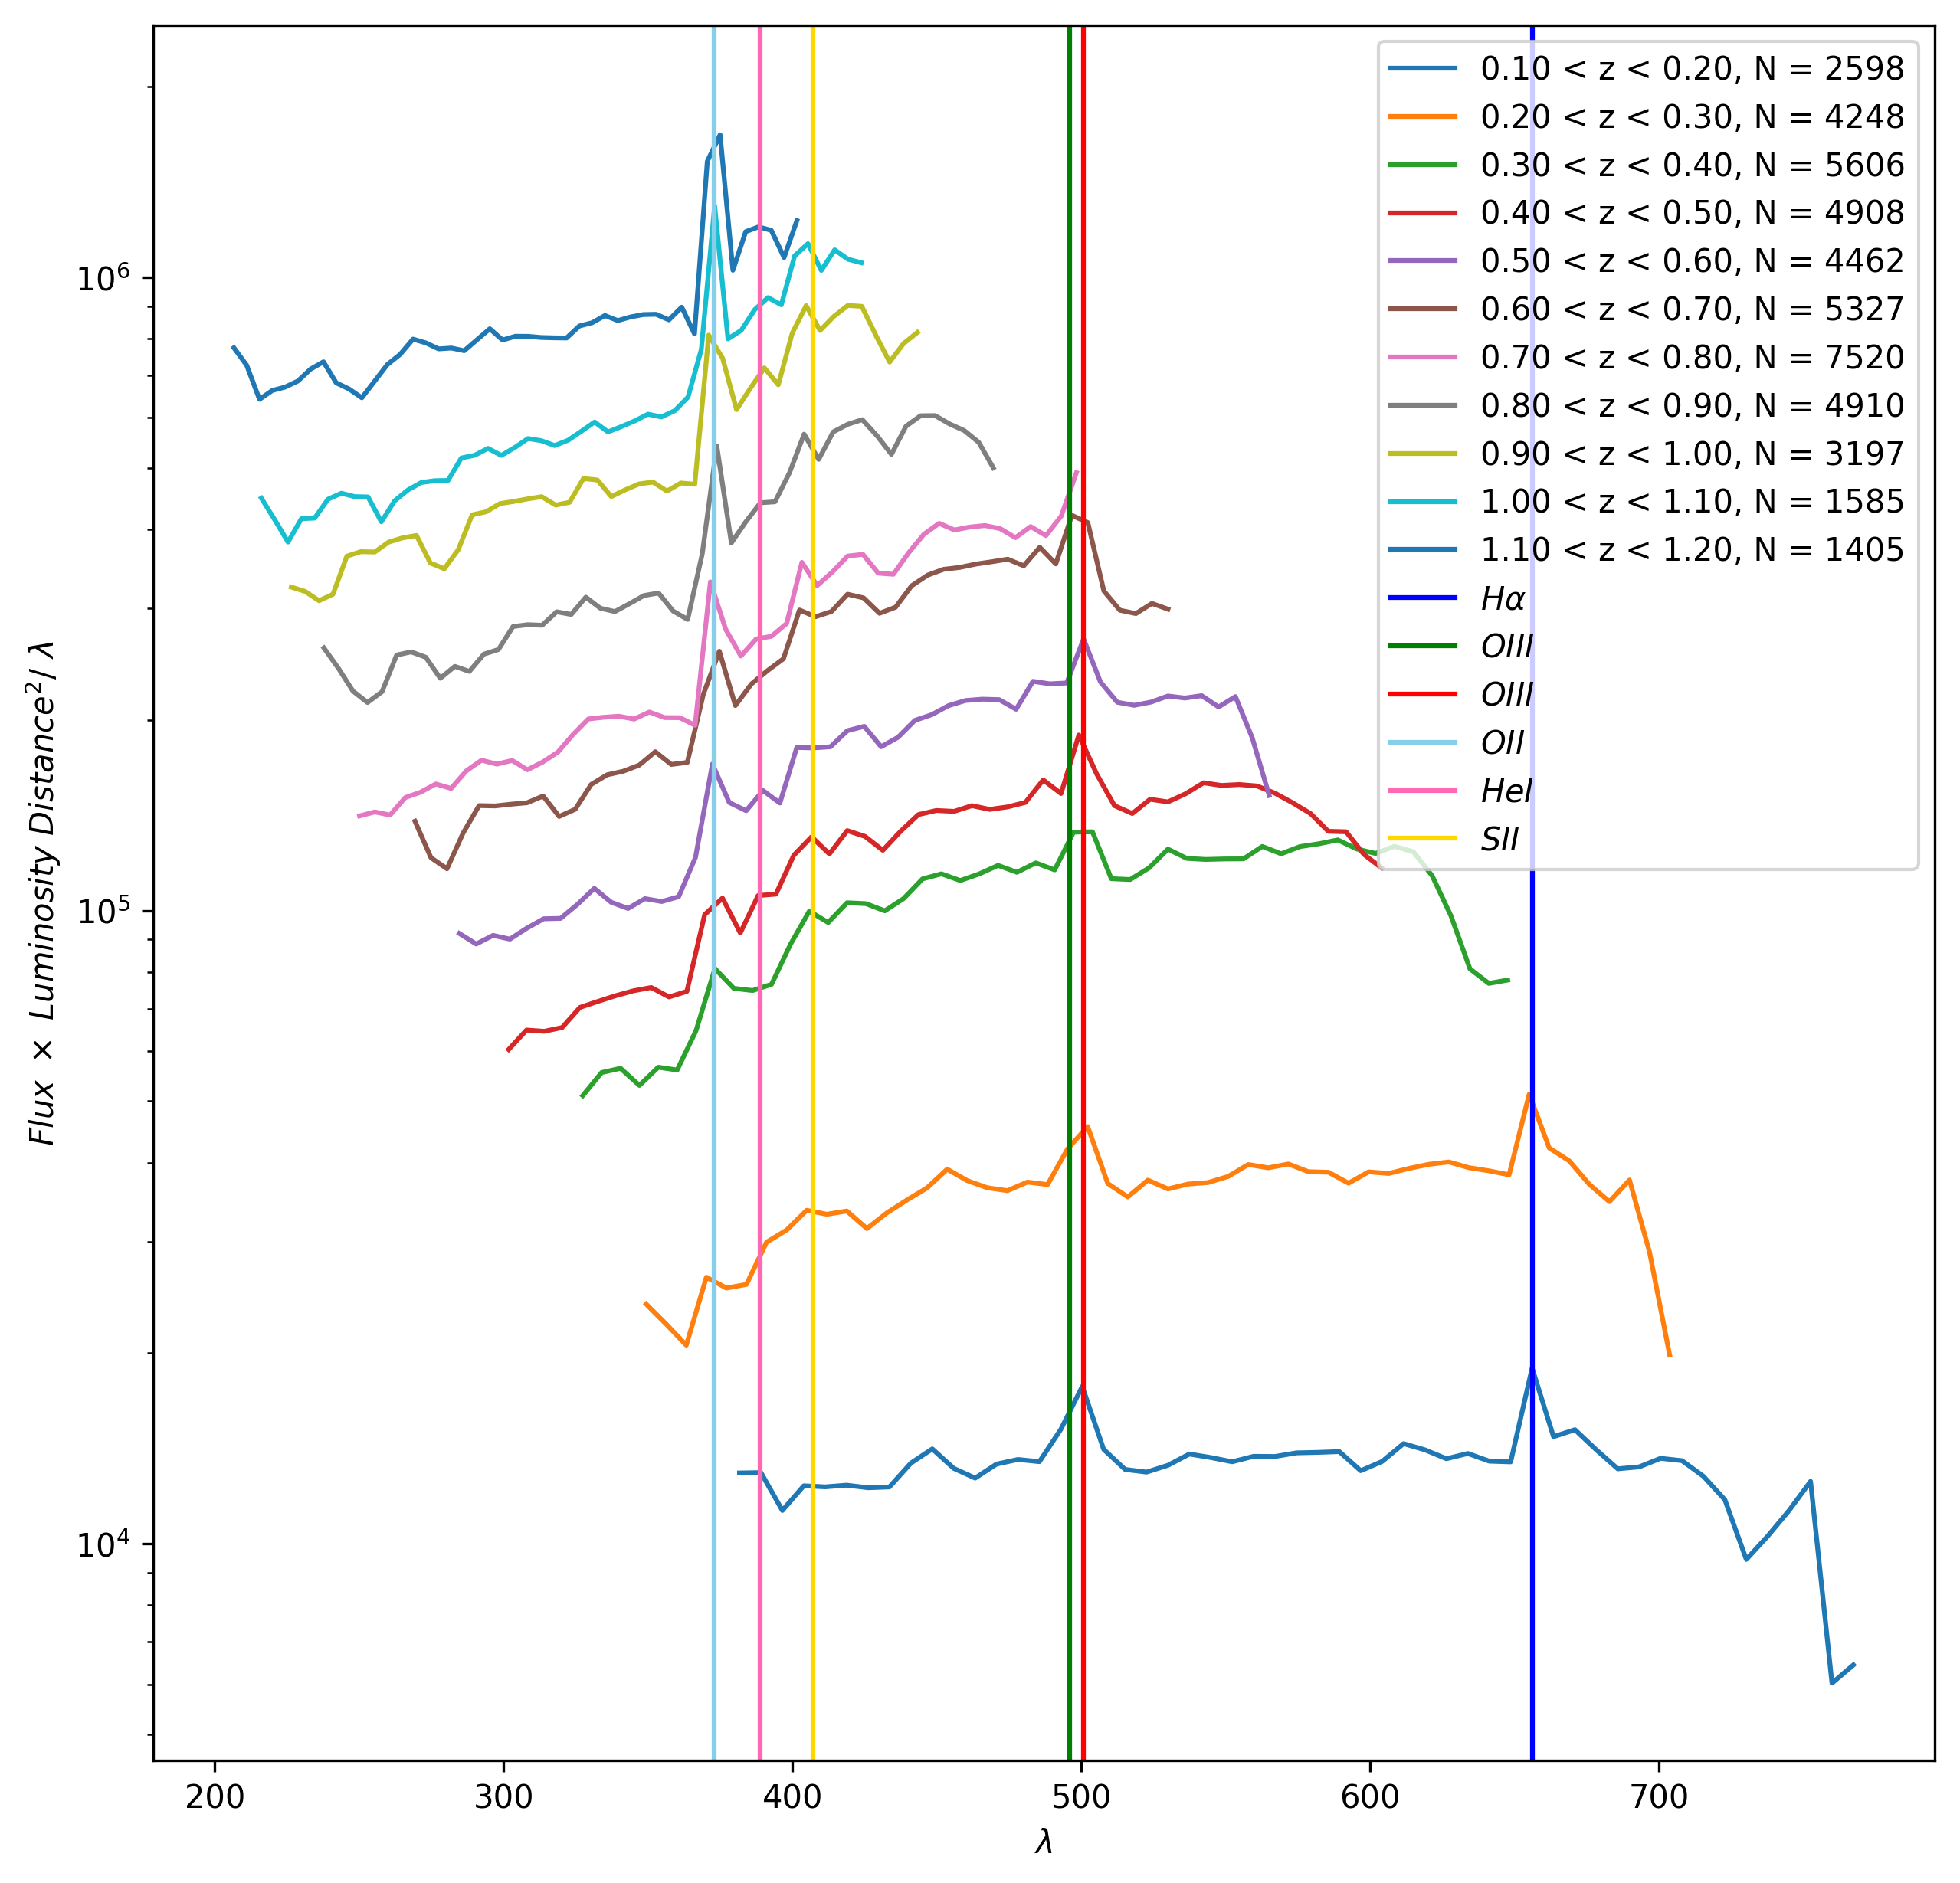

In [7]:
# bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]
bins = []
bin_range = [0.1,1.2]
bin_increment = 0.1
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]]) 

# bins = [[0.7,0.75],[0.75,0.8],[0.8,0.85]]
fig = plt.figure(figsize=(10,10),dpi=300)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# print(band_obsframe.min(),band_obsframe.max())

increments = np.linspace(90,150,len(bins))

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])
# band_bins = np.arange(200,860,band_bin_incs[ind])

for ind,z_bin in enumerate(bins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
    print("wl bin step = {:3.2f}".format(step))
#     print(band_bins)
    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1])
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    lum_dist_sample = luminosity_distances[truth_table].flatten()
#     print(lamb_sample.shape,flux_sample.shape,lum_dist_sample.shape)
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
    binned_means = [np.nanmedian(flux_sample[digitized == i] * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
#     print (binned_means)
    
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
             label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
# plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]
colours = ['blue','green','red','skyblue','hotpink','gold','black','white']
for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],label=line[1],color=colours[i])

plt.xlabel(r'$\lambda$')
plt.ylabel(r'$Flux\ \times\ Luminosity\ Distance^2 /\ \lambda$')
plt.legend()
plt.yscale('log')
plt.ylim([0,2.5e6])
#plt.xlim([200,680])
plt.show()


/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


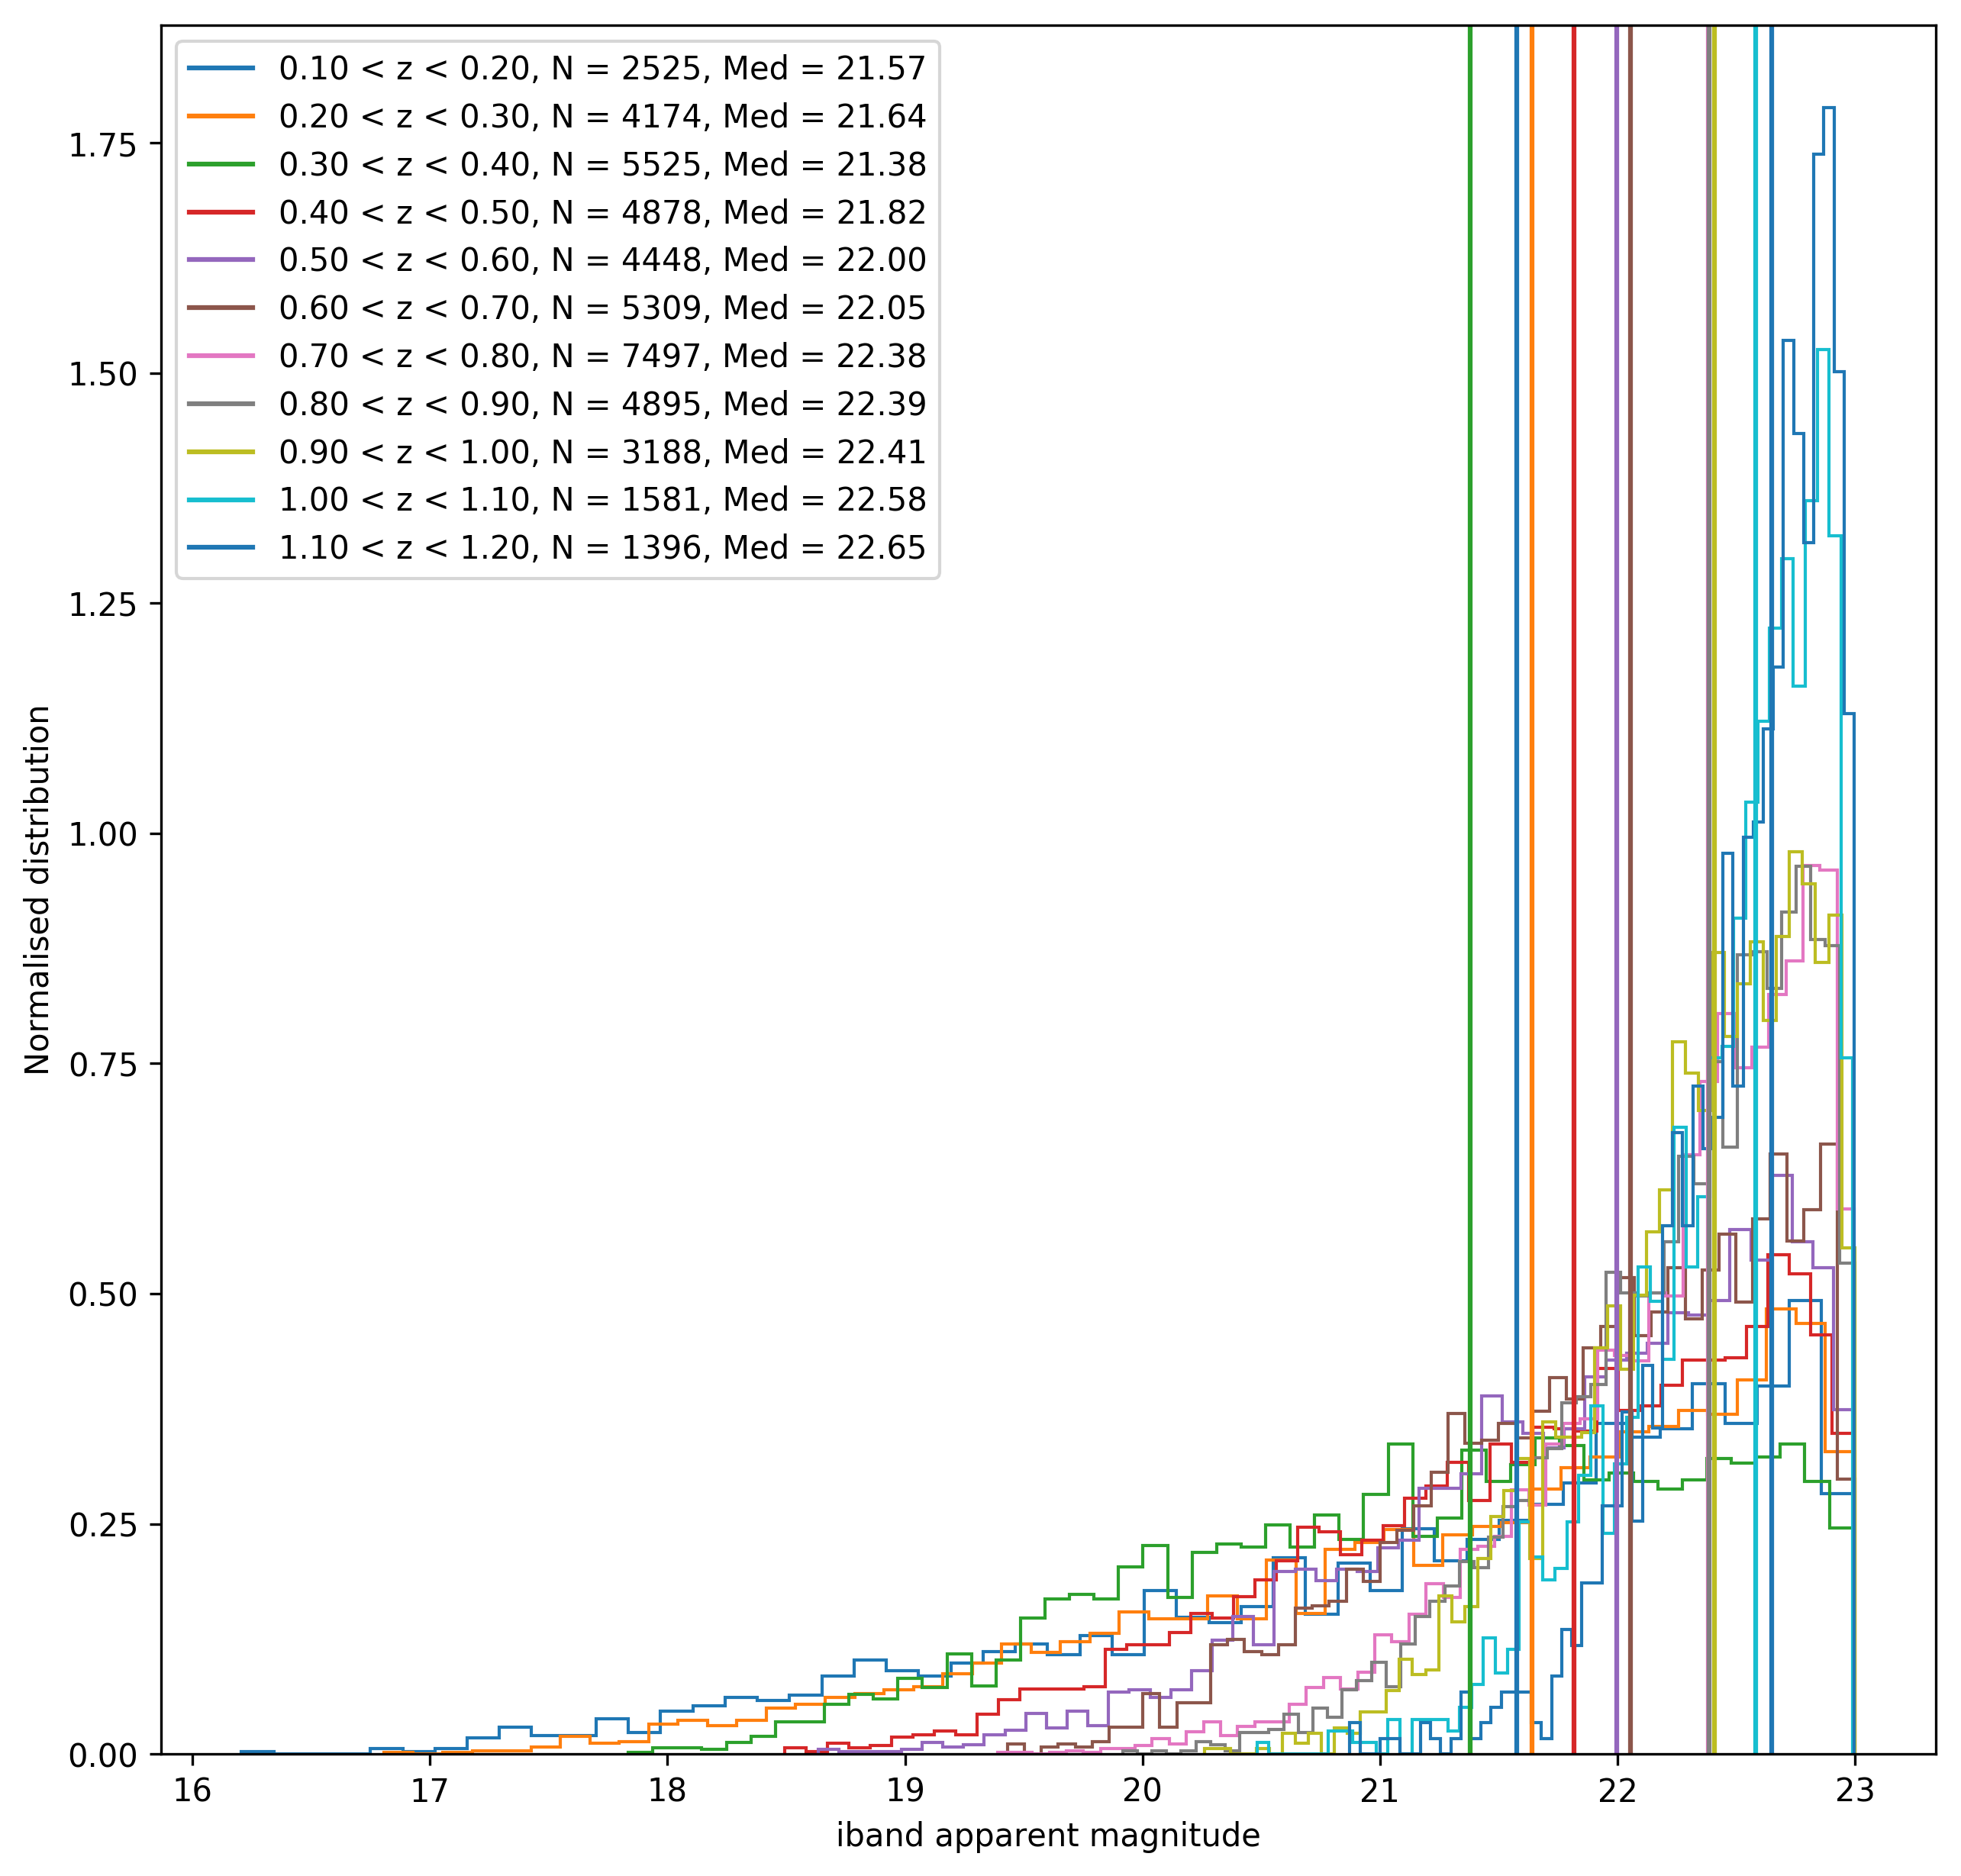

In [8]:
plt.figure(figsize=(10,10),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.1
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

for ind,z_bin in enumerate(bins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1]) & (data_sample['imag']!=0)
    
#     lamb_sample = band_obsframe[truth_table].flatten()
    
    iband_mags = data_sample.loc[truth_table,'i_auto']
    N_objects = iband_mags.size
    median = np.median(iband_mags)
#     digitized = np.digitize(lamb_sample,band_bins)
#     binned_means = [np.nanmedian(iband_mags[digitized == i]) for i in range(1,len(band_bins))]
    hist = plt.hist(iband_mags,50,histtype='step',density=True)
    plt.axvline(median,color=hist[-1][0].get_edgecolor(),label='{:.02f} < z < {:.02f}, N = {}, Med = {:4.2f}'\
                .format(z_bin[0],z_bin[1],N_objects,median))

plt.xlabel('iband apparent magnitude')
plt.ylabel('Normalised distribution')
plt.legend()
plt.show()
    

/home/andrew/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if sys.path[0] == '':


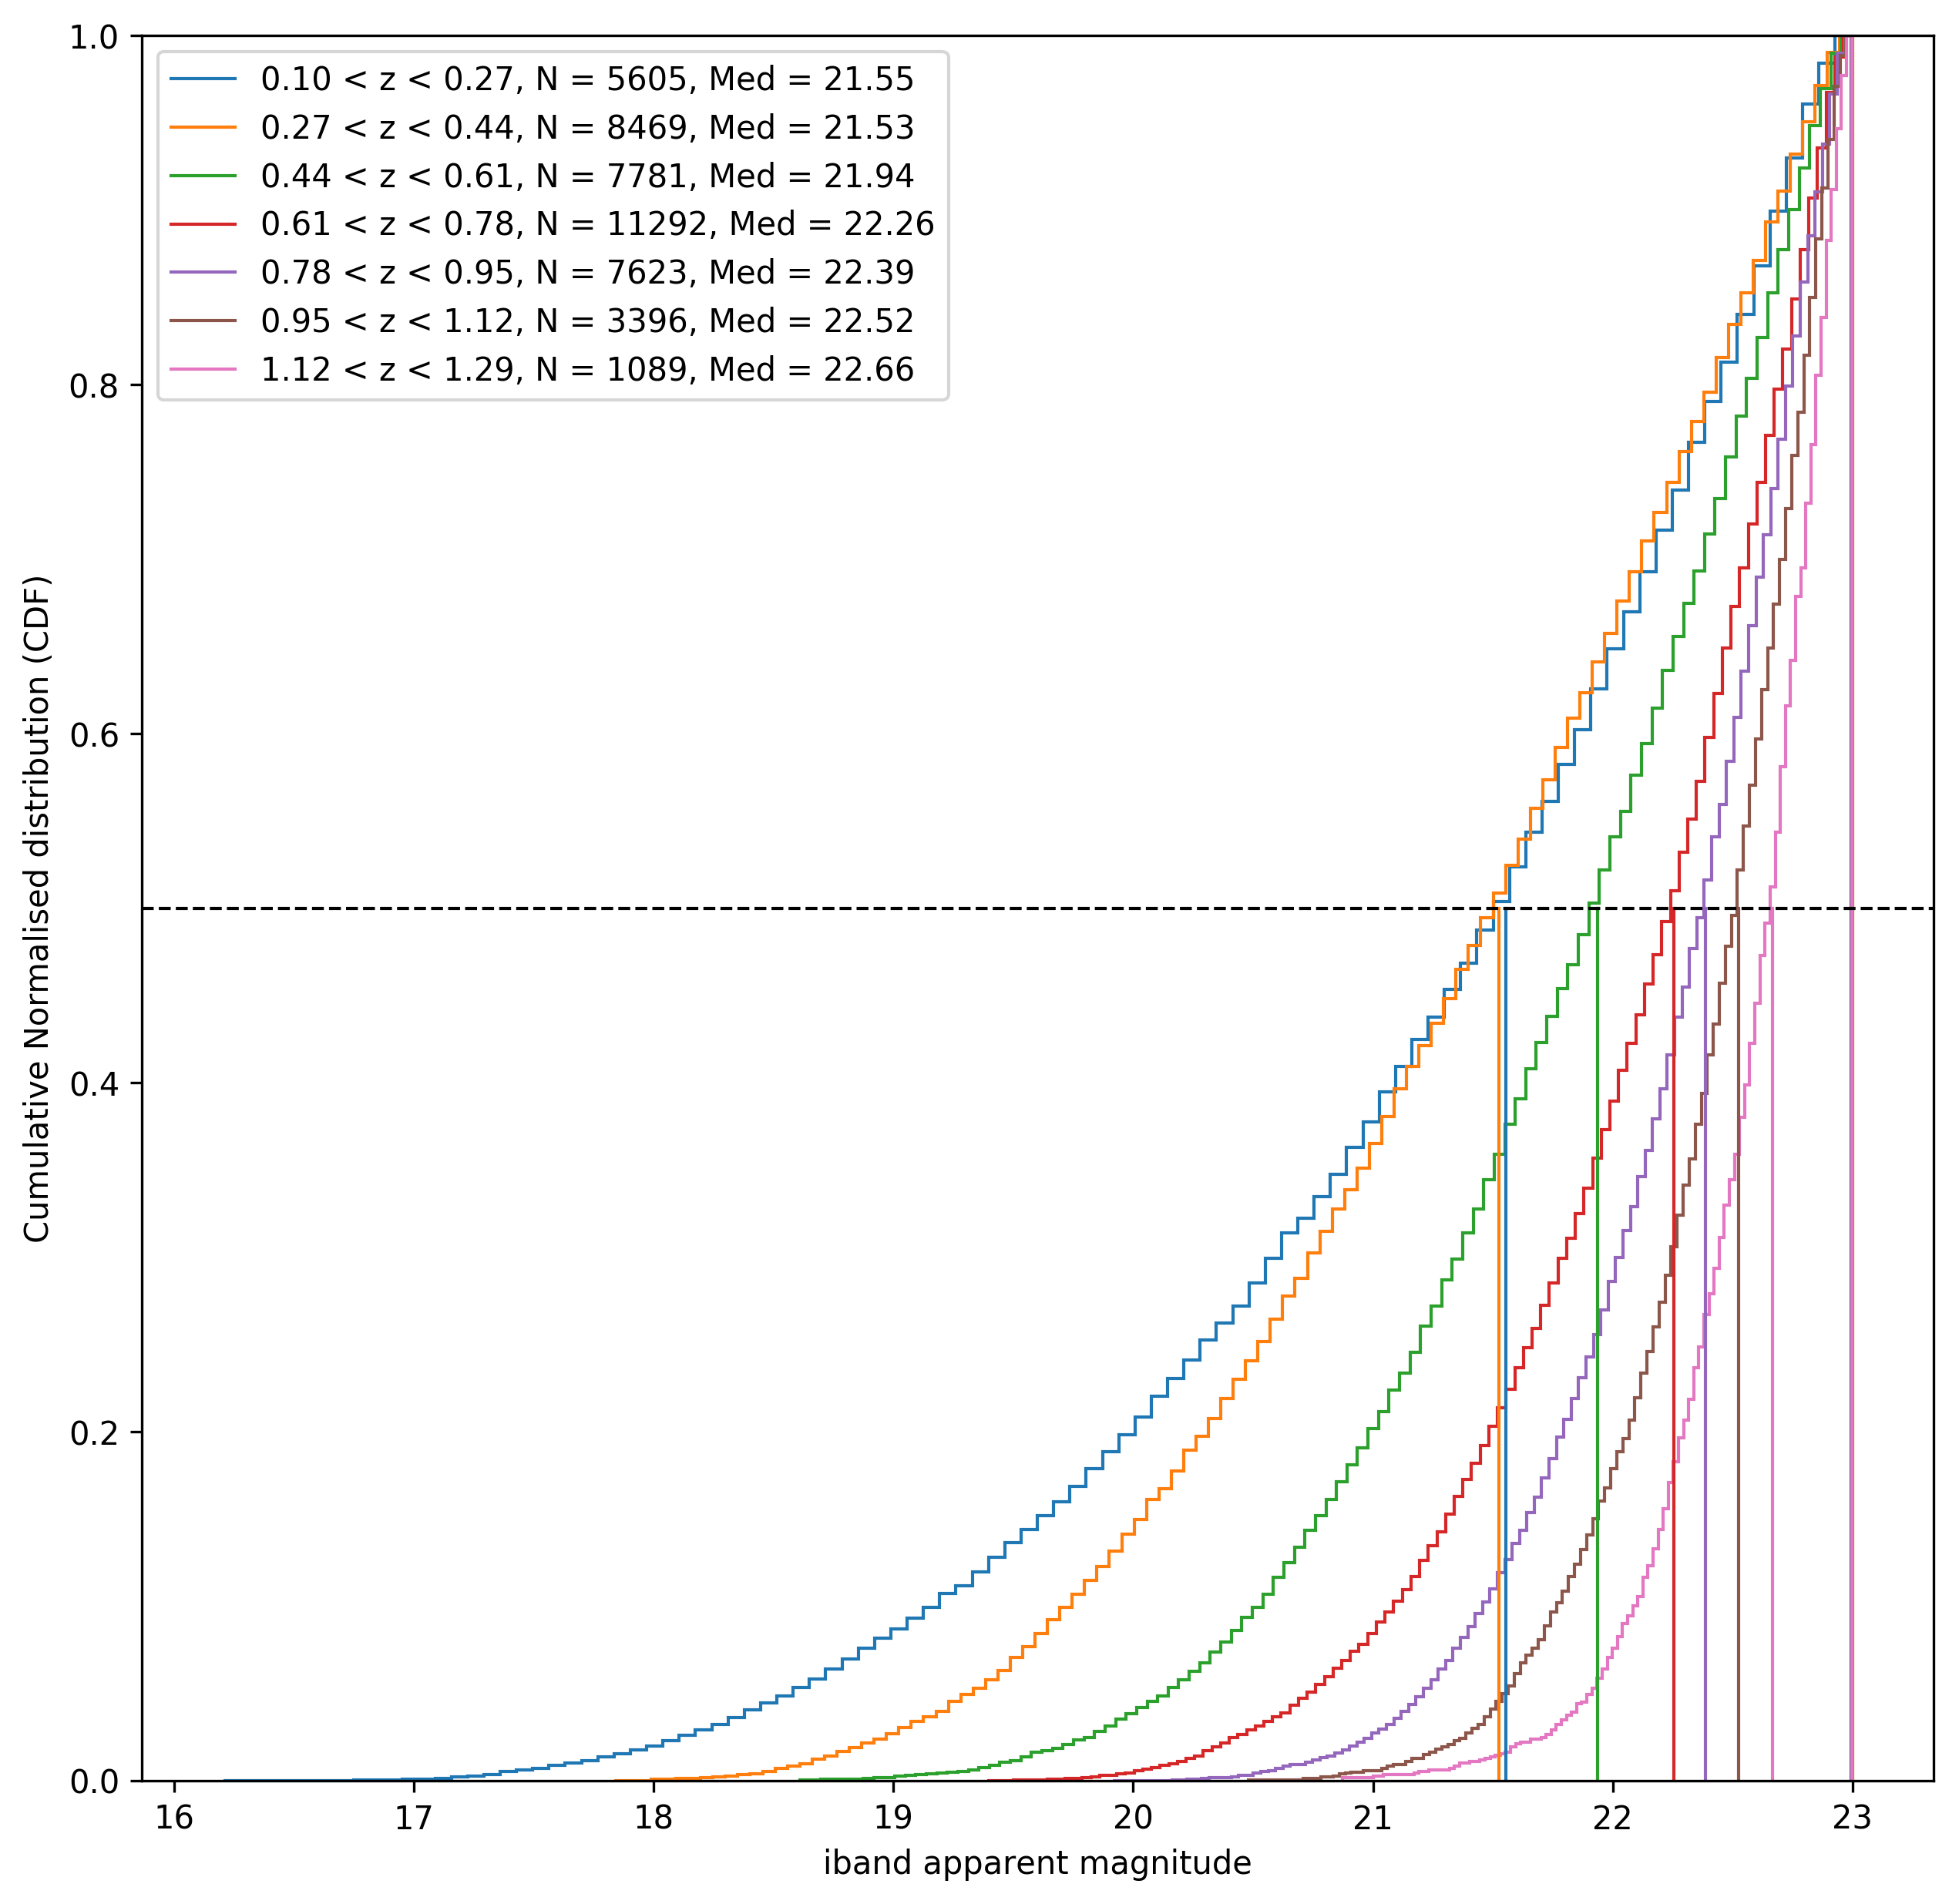

In [9]:
plt.figure(figsize=(10,10),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.17
temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
for ind,i in enumerate(temp_bins[:-1]):
    bins.append([temp_bins[ind],temp_bins[ind+1]])

increments = np.linspace(90,150,len(bins))
for ind,z_bin in enumerate(bins):
    band_bins,step = np.linspace(200,860,increments[ind],retstep=True)
#     print("wl bin step = {:3.2f}".format(step))

    truth_table = (z_photos >= z_bin[0]) & (z_photos <= z_bin[1]) & (data_sample['imag']!=0)
    
#     lamb_sample = band_obsframe[truth_table].flatten()
    
    iband_mags = data_sample.loc[truth_table,'i_auto']
    N_objects = iband_mags.size
    median = np.median(iband_mags)
#     digitized = np.digitize(lamb_sample,band_bins)
#     binned_means = [np.nanmedian(iband_mags[digitized == i]) for i in range(1,len(band_bins))]
    hist = plt.hist(iband_mags,100,histtype='step',density=True,cumulative=True)#,label='{:.02f} < z < {:.02f}, N = {}'.format(z_bin[0],z_bin[1],N_objects))
    plt.axvline(median,ymax=0.5,color=hist[-1][0].get_edgecolor(),linewidth=1,\
                label='{:.02f} < z < {:.02f}, N = {}, Med = {:4.2f}'.format(z_bin[0],z_bin[1],N_objects,median))

plt.axhline(0.5,color='black',linewidth=1,linestyle='--')
plt.xlabel('iband apparent magnitude')
plt.ylabel('Cumulative Normalised distribution (CDF)')
plt.ylim((0,1))
plt.legend()
plt.show()
    

# ML Run

In [10]:
ML_DATA = pd.read_csv("../../ML runs/PAUS_advanced1/regres/eval_nFile0/ANNZ_randomReg_0000.csv")
# ML_DATA

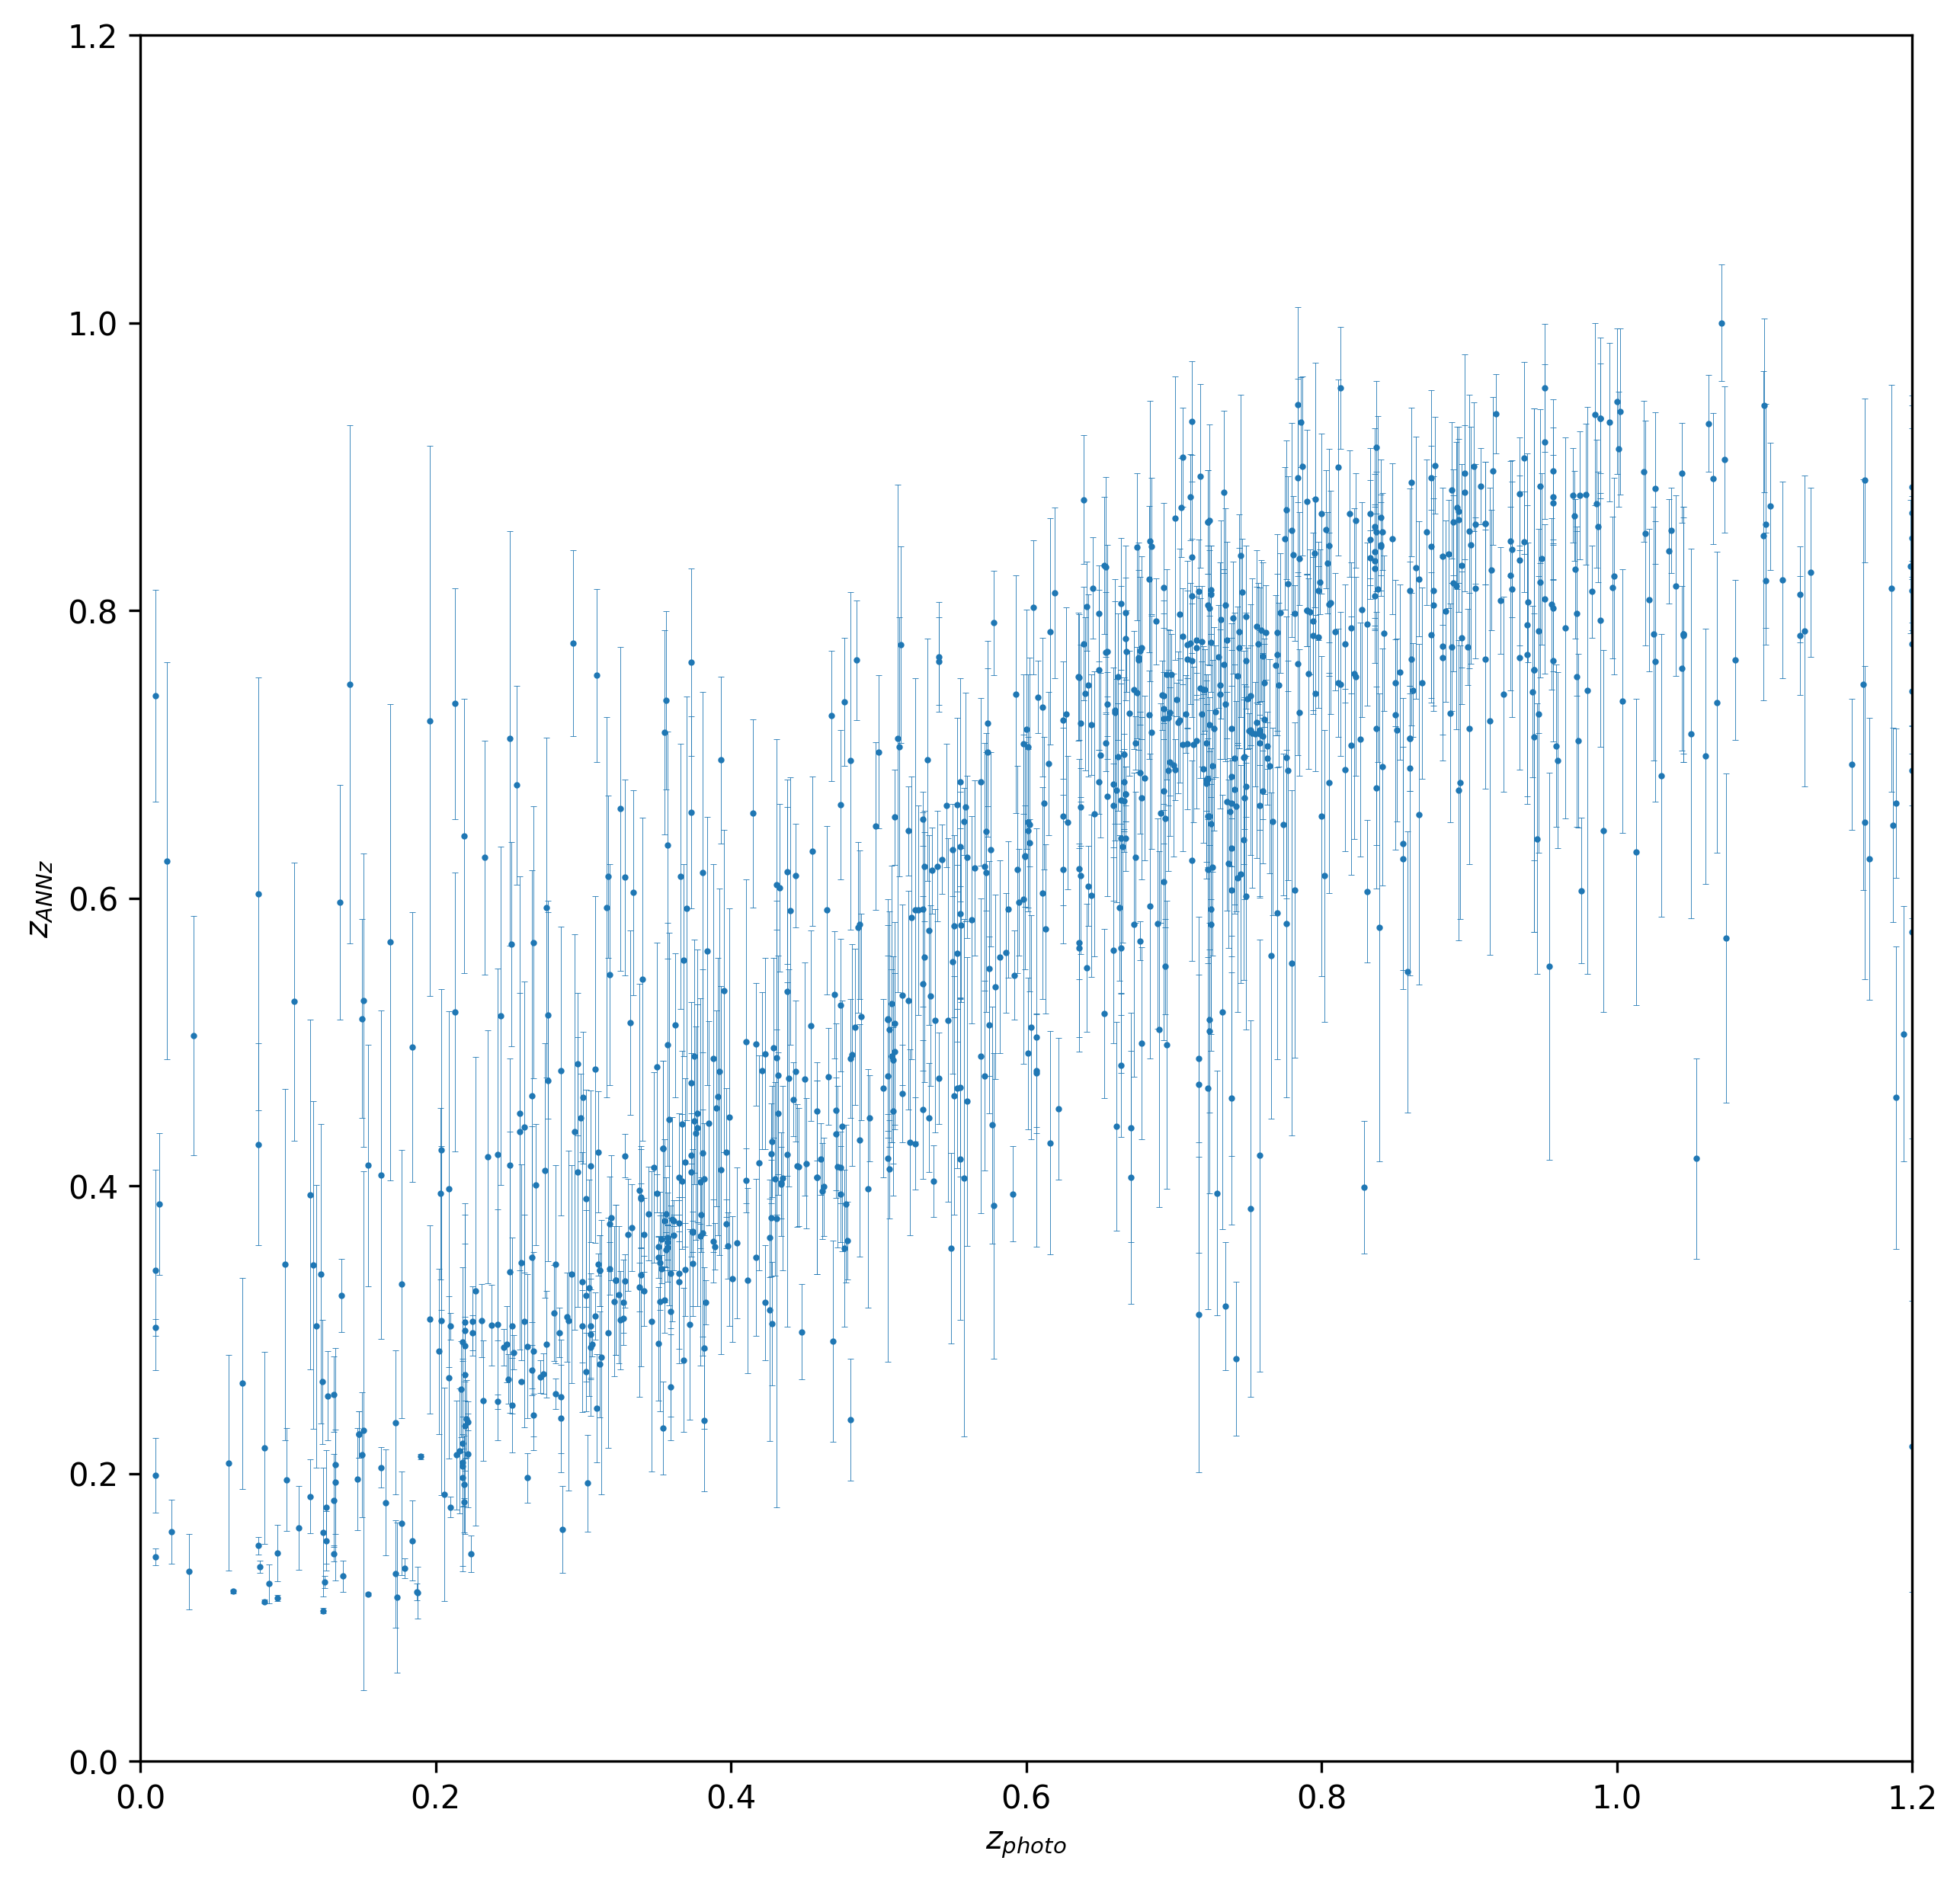

In [11]:
# ML_DATA
indices = np.random.randint(0,ML_DATA.shape[0],1000)

plt.figure(figsize=(10,10),dpi=300)
plt.errorbar(ML_DATA.loc[indices,'F:Z'],ML_DATA.loc[indices,'F:ANNZ_best'],yerr=ML_DATA.loc[indices,'F:ANNZ_best_err']\
             ,fmt='o',ms=1,linewidth=0.2,capsize=1,capthick=0.2)
# plt.plot((0,1.2),(0,1.2),'k--',linewidth=1)
plt.xlabel(r'$z_{photo}$')
plt.ylabel(r'$z_{ANNz}$')
plt.xlim(0,1.2)
plt.ylim(0,1.2)

plt.show()

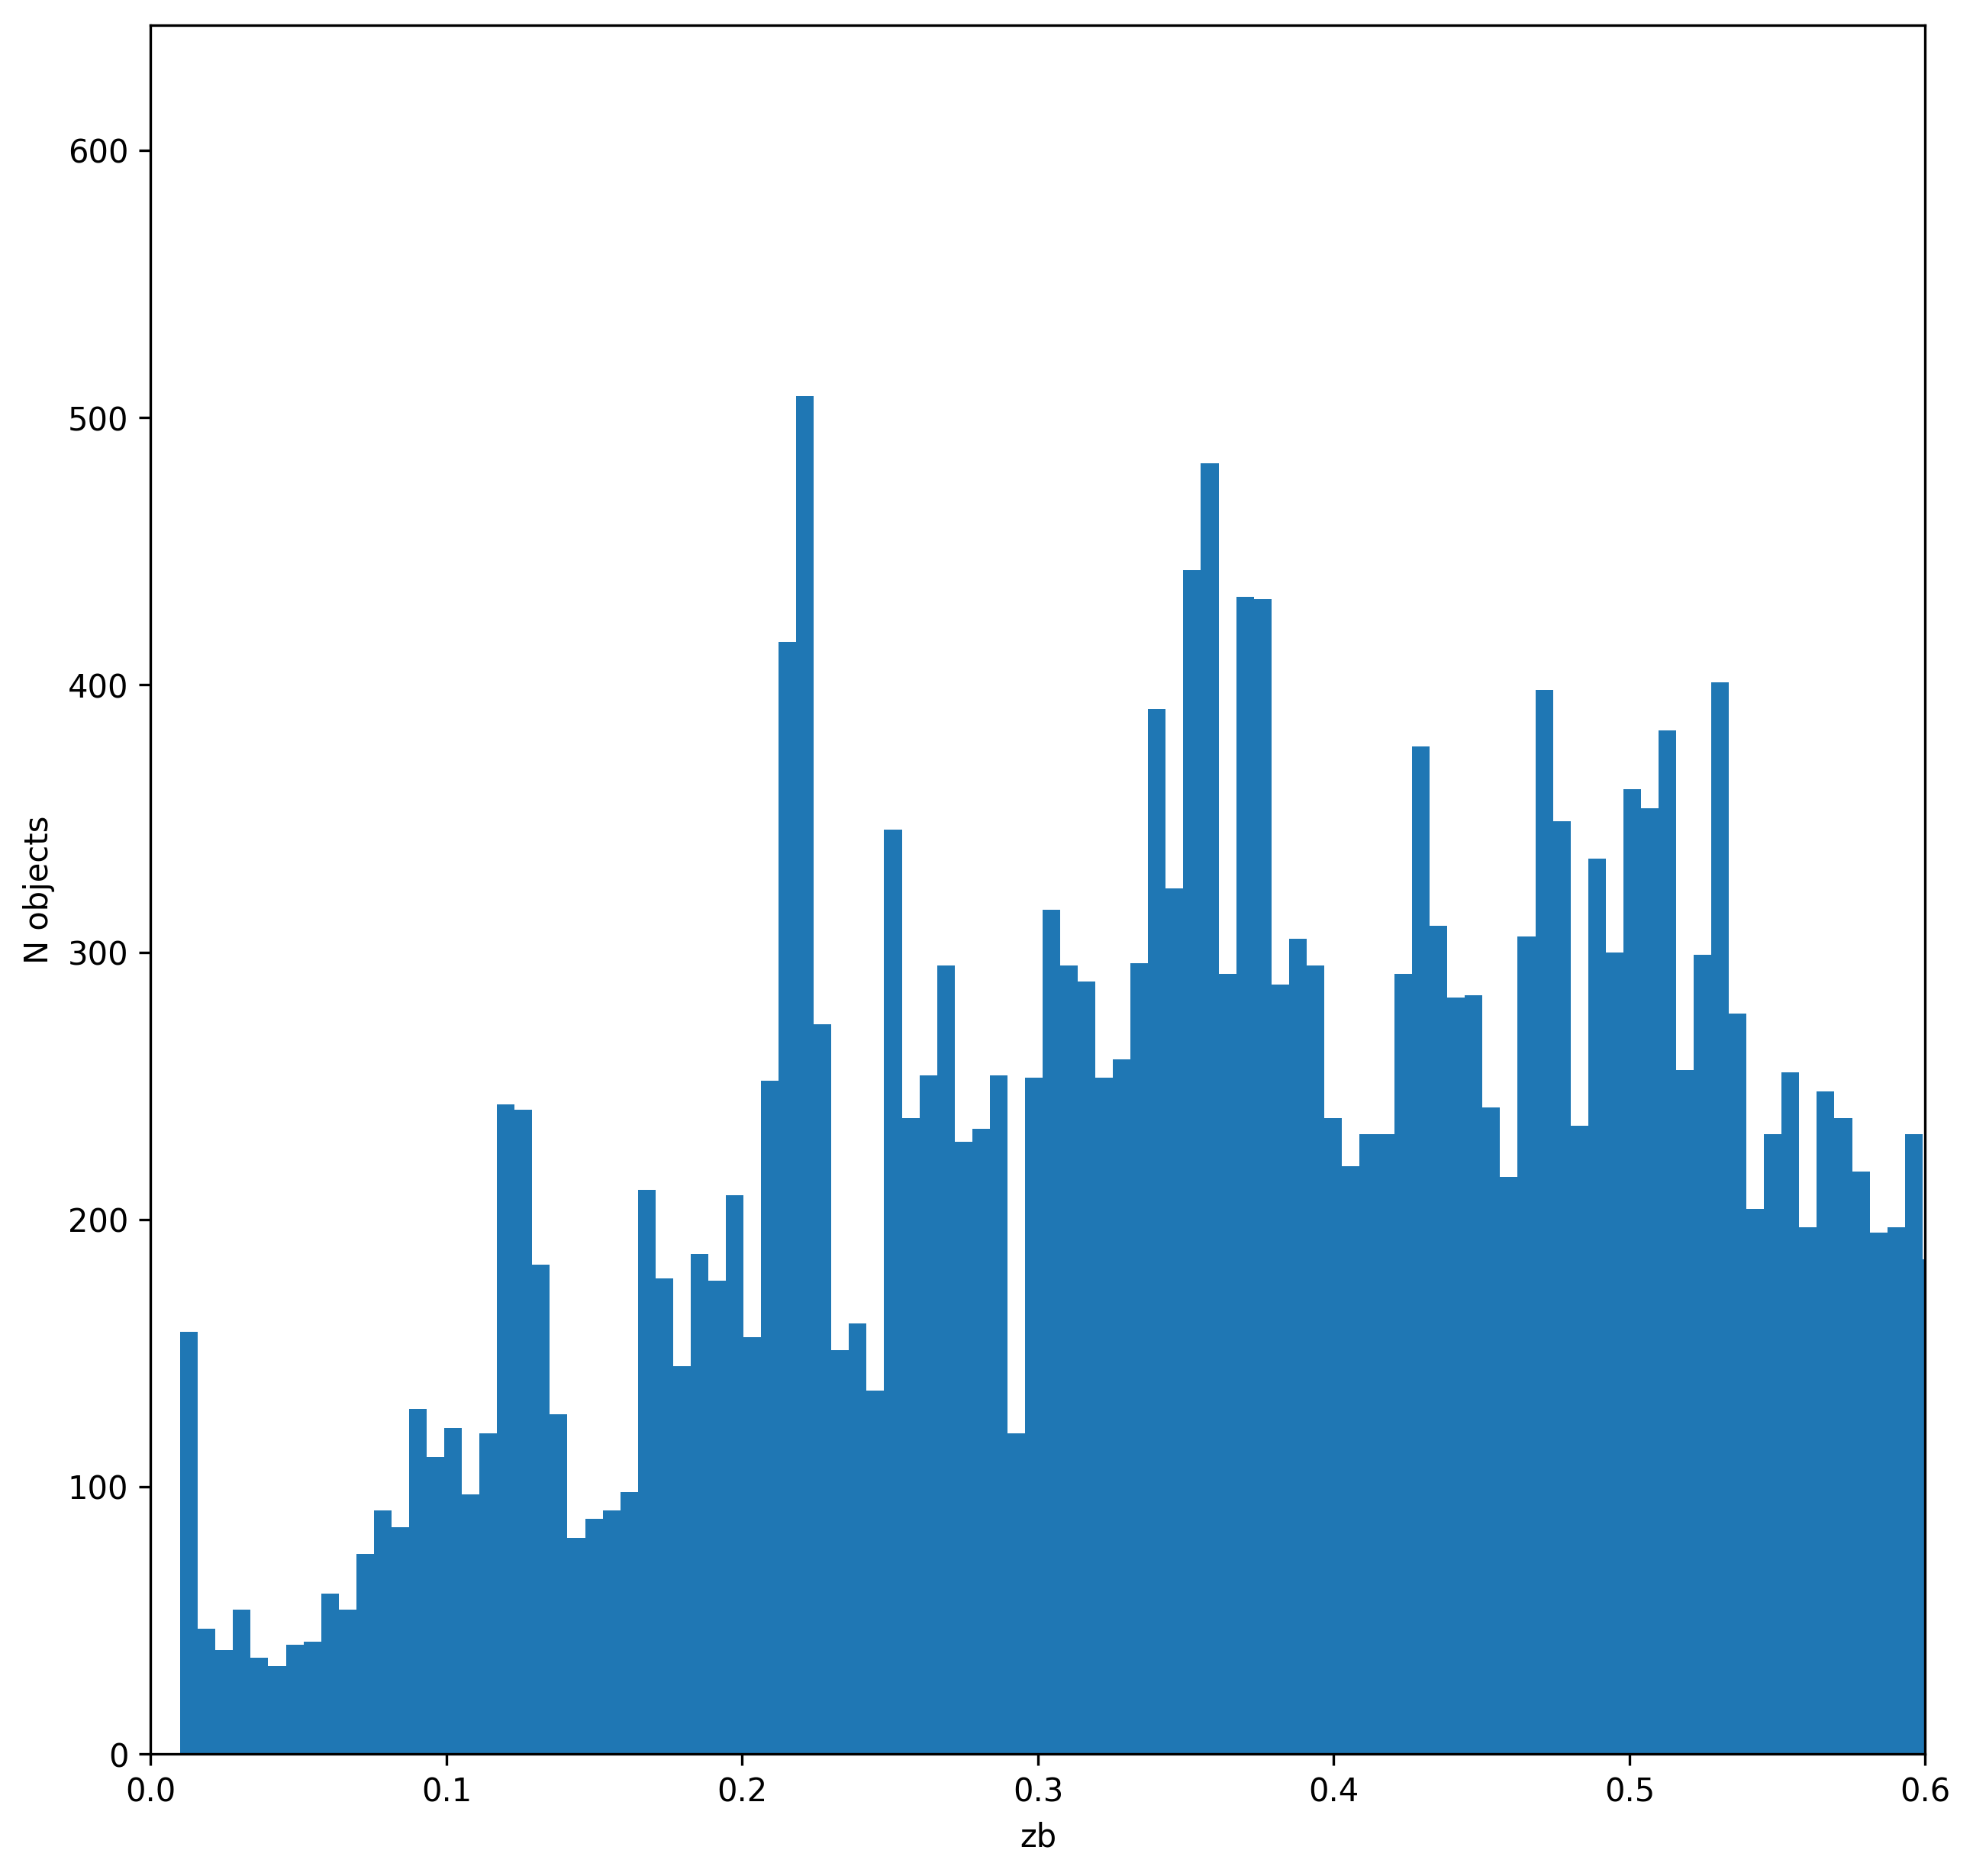

In [15]:

plt.figure(figsize=(10,10),dpi=300)
plt.hist(data_sample['zb'],200)
plt.xlim(0,0.6)
plt.xlabel('zb')
plt.ylabel('N objects')
plt.show()

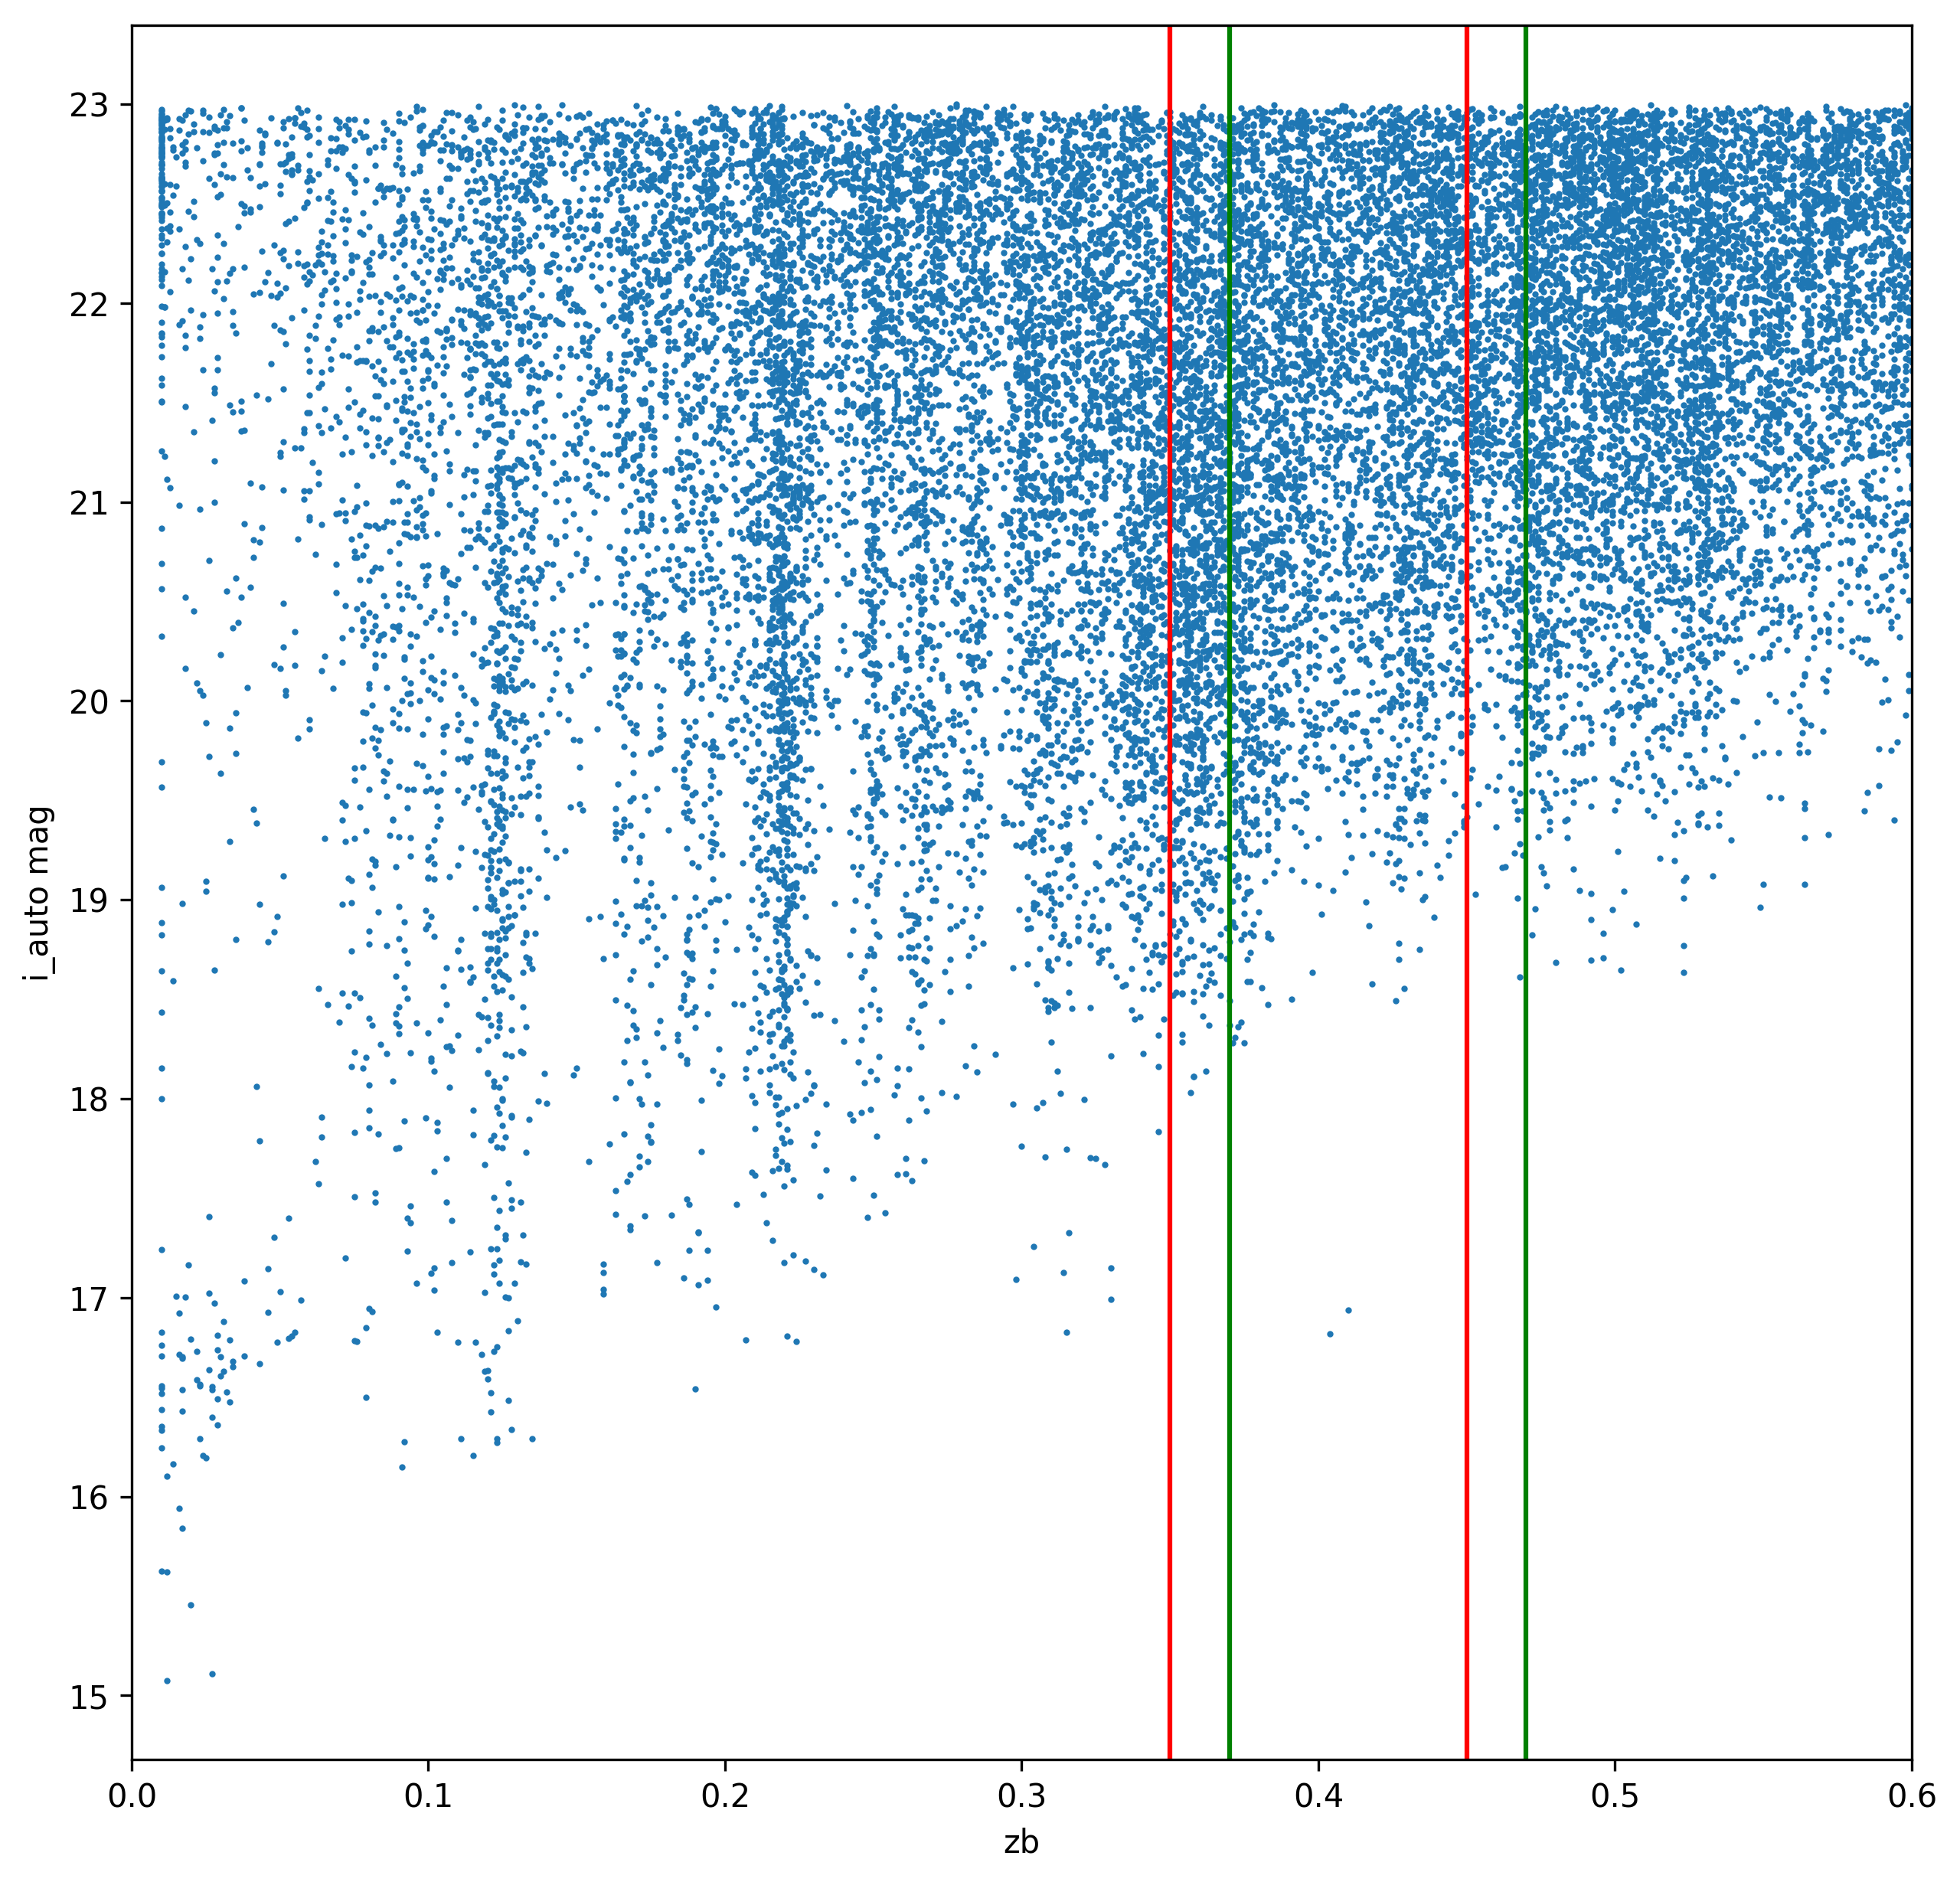

In [16]:
plt.figure(figsize=(10,10),dpi=300)
plt.scatter(data_sample['zb'],data_sample['i_auto'],s=1)
plt.axvline(0.35,color='red')
plt.axvline(0.45,color='red')
plt.axvline(0.37,color='green')
plt.axvline(0.47,color='green')
plt.xlim((0,0.6))
plt.xlabel('zb')
plt.ylabel('i_auto mag')
plt.show()